In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.datasets import load_digits
from sklearn.metrics import confusion_matrix

from seaborn import despine
import seaborn as sns
sns.set_style("ticks")
sns.set_context("talk")

from IPython.display import Image

import matplotlib.pyplot as plt
%matplotlib inline

# 1. Example 2: What if the data is not linearly separable?

In the previous notebook (0-Perceptron-Gradient-Descent.iypnb), we have learned that we can use the perceptron algorithm to build a binary classifier for linearly separable data (by learning a  hyperplane).

Yet, not all data is linearly separable. Take a look at the figure below and try to find a line that separates the blue and red dots:

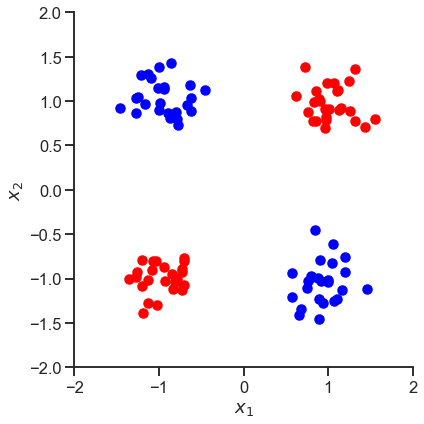

In [2]:
np.random.seed(4128)

n_samples = 50

# generate data
X1 = []
X2 = []
for sample in range(n_samples):
    # class 1
    if np.random.uniform(0,1,1) > 0.5:
        X1.append(np.array([np.random.normal(-1,0.2,1), np.random.normal(1,0.2,1)]).reshape(1,-1))
    else:
        X1.append(np.array([np.random.normal(1,0.2,1), np.random.normal(-1,0.2,1)]).reshape(1,-1))
    # class 2  
    if np.random.uniform(0,1,1) > 0.5:
        X2.append(np.array([np.random.normal(-1,0.2,1), np.random.normal(-1,0.2,1)]).reshape(1,-1))
    else:
        X2.append(np.array([np.random.normal(1,0.2,1), np.random.normal(1,0.2,1)]).reshape(1,-1))
X = np.concatenate([np.concatenate(X1), np.concatenate(X2)])
y = np.zeros((X.shape[0],1))
y[n_samples:] = 1
y = y.astype(np.int)

# plot the training data
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(X[(y==0).ravel(),0], X[(y==0).ravel(),1], c='b')
ax.scatter(X[(y==1).ravel(),0], X[(y==1).ravel(),1], c='r')
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
despine(ax=ax)

fig.tight_layout()
fig.savefig('figures/Figure-1-0_Not-Linaerly-Separable.png', dpi=600)

Mh. I don't think it is  possible to separate the blue and red points with a single line.

Yet, the data would be easily separable if we could use two decision boundaries (or one that is not linear).

So how do we train a classifier for this problem?

# 2. XOR with multiple perceptrons

Couldn't we just combine multiple perceptrons to solve this classification problem?

We could train one perceptron to distinguish the red point cloud in the lower left from all others and another perceptron to distinguish the red point cloud in the top right from all others. Subsequently, we could train a third perceptron based on the predictions of the first two: if either of the first two predicts that a data point belongs to their target class (so if either predicts $y=1$), the third perceptron would also predict $y=1$. 

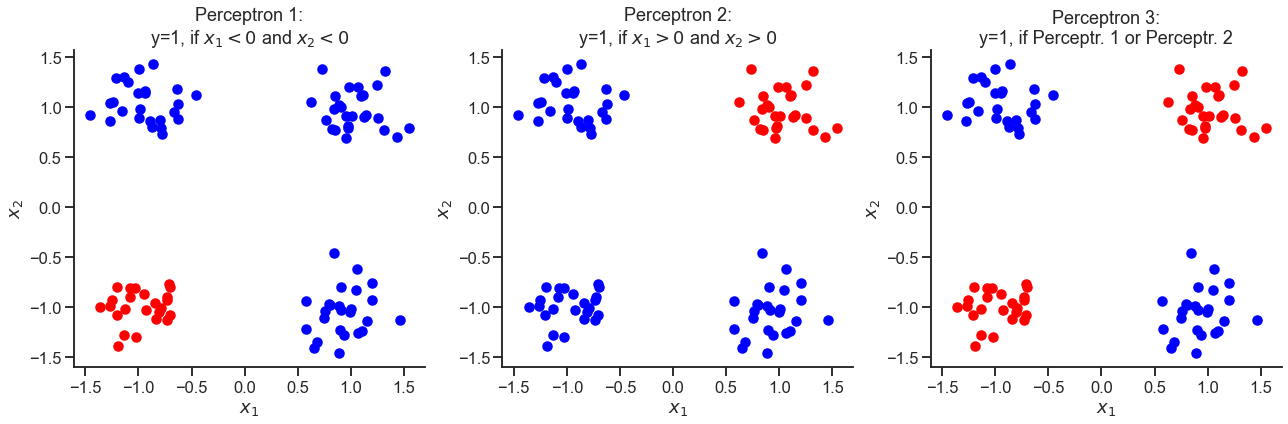

In [3]:
fig, axs = plt.subplots(1,3,figsize=(18,6))

# perceptron 1
axs[0].set_title('Perceptron 1:\n'+'y=1, if '+r'$x_1<0$'+' and '+r'$x_2<0$')
idx1 = np.logical_and(X[:,0]<0, X[:,1]<0)
axs[0].scatter(X[idx1,0], X[idx1,1], color='red')
axs[0].scatter(X[~idx1,0], X[~idx1,1], color='blue')

# perceptron 2
axs[1].set_title('Perceptron 2:\n'+'y=1, if '+r'$x_1>0$'+' and '+r'$x_2>0$')
idx2 = np.logical_and(X[:,0]>0, X[:,1]>0)
axs[1].scatter(X[idx2,0], X[idx2,1], color='red')
axs[1].scatter(X[~idx2,0], X[~idx2,1], color='blue')

# perceptron 3
axs[2].set_title('Perceptron 3:\n'+'y=1, if Perceptr. 1 or Perceptr. 2')
idx3 = np.logical_or(idx1, idx2)
axs[2].scatter(X[idx3,0], X[idx3,1], color='red')
axs[2].scatter(X[~idx3,0], X[~idx3,1], color='blue')

for ax in axs:
    despine(ax=ax)
    ax.set_xlabel(r'$x_1$')
    ax.set_ylabel(r'$x_2$')
fig.tight_layout()

# save
fig.savefig('figures/Figure-1-1_Multi-Perceptron-Classification.png', dpi=600)

This is a cool idea, let's see if we can get this implemented.

To make the computational setup more clear, I have created a sketch of how the three perceptrons would work together:

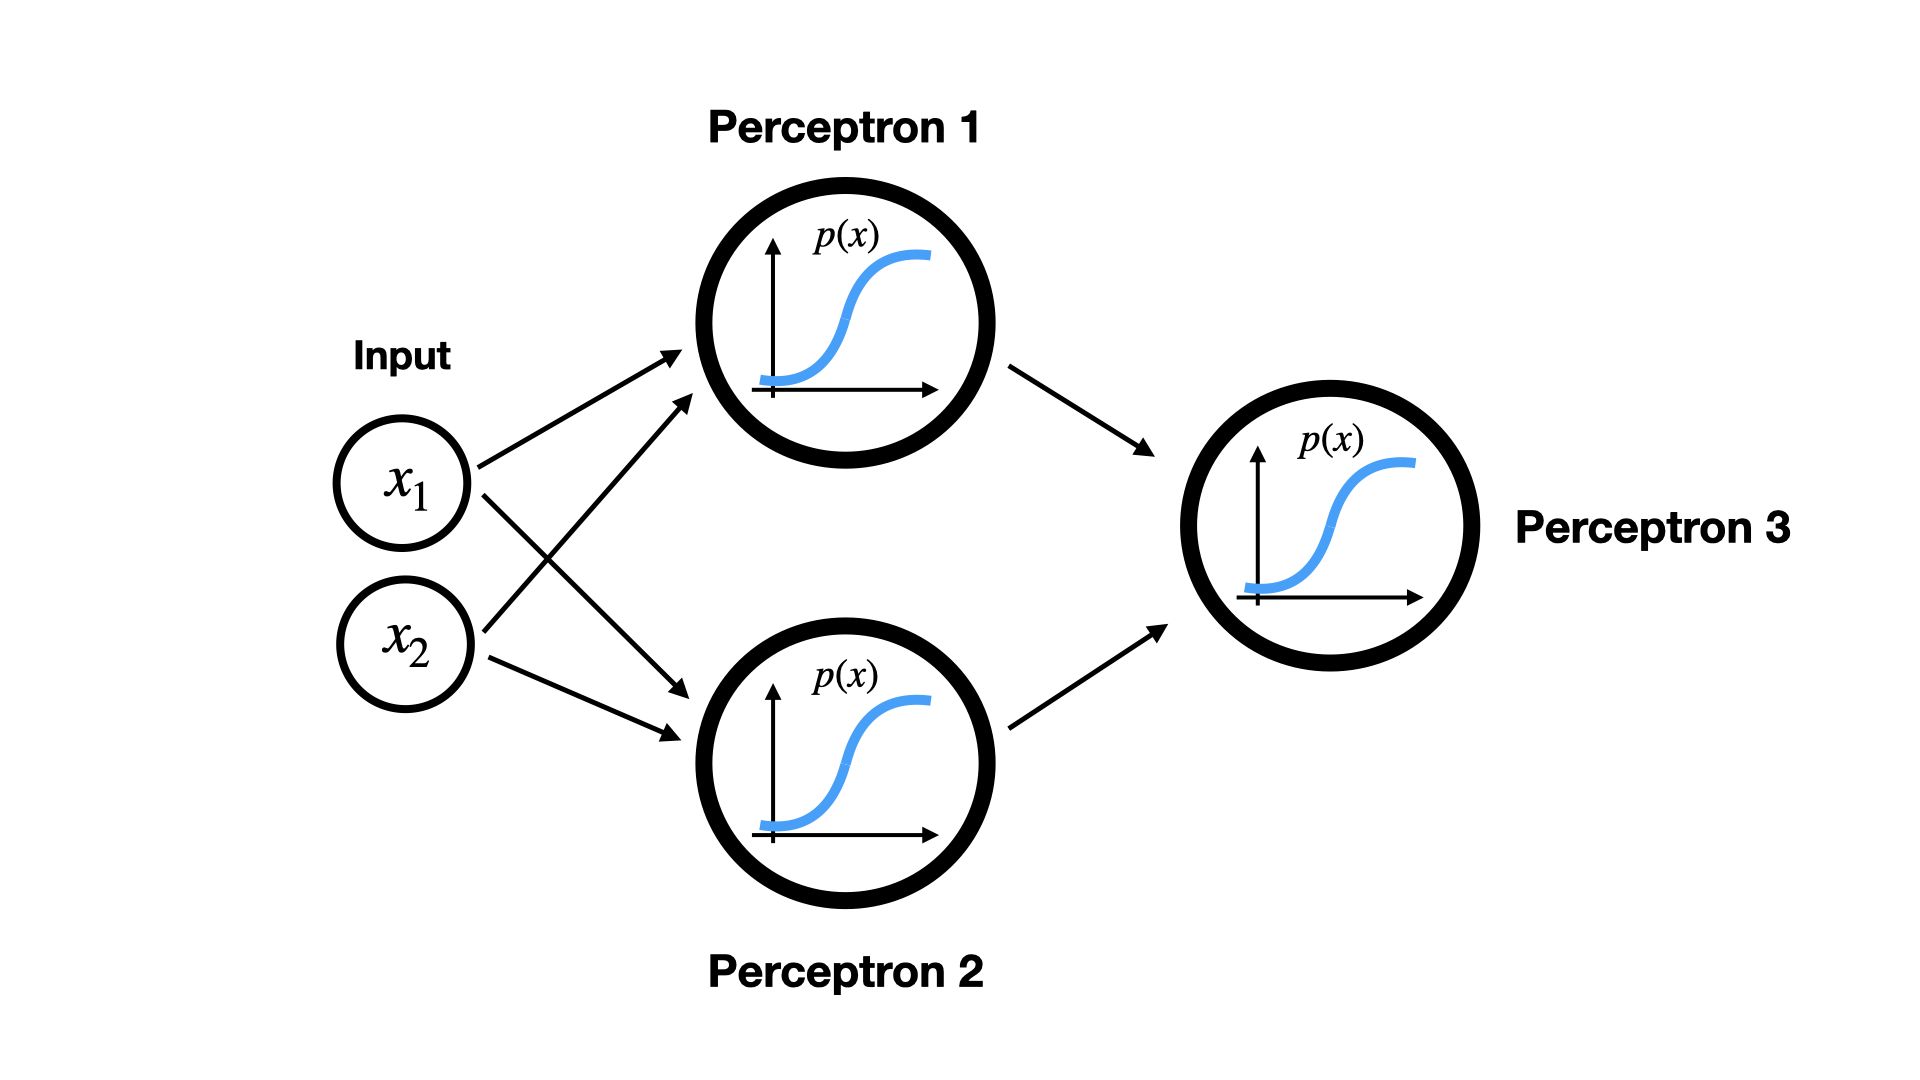

In [4]:
Image(filename='materials/images/free-use/Multilayer-Perceptron.png')

To set this up, we will again use our perceptron implementation from the previous notebook:

In [5]:
def sigmoid(x):
    """the sigmoid function
    """
    return 1.0/(1.0 + np.exp(-x)) 

In [6]:
class cross_entropy_loss:
    def __init__(self):
        name = 'cross entropy'
        
    def loss(self, y, y_pred, zerotol=1e-10):
        """the cross-entropy loss:
        
        Args:
            y (array): labels for each insatance (0 or 1)
            y_pred (array): predicted probabilty that
                each instance belongs to class 1
        """
        loss = -(y * np.log(y_pred + zerotol) + (1 - y) * np.log(1 - y_pred + zerotol))
        return loss
    
    def derivative_loss(self, y, y_pred):
        """the derivative of the cross-entropy loss w.r.t. 
        to sigmoid activation function
        (we will get to this later)
        
        Args:
            y (array): labels for each insatance (0 or 1)
            y_pred (array): predicted probabilty that
                each instance belongs to class 1
        """
        return y_pred - y

In [7]:
class Perceptron:
    
    def __init__(self, n_in, activation=sigmoid, loss=cross_entropy_loss, b=None):
        """A simple perceptron implementation.
        
        Args:
            n_in (int): number of input features for each instance
            activation (function): activation function of the perceptron
            loss (function): loss function that we use; 
                this should be cross_entropy for sigmoid activations
            b (float): bias term; if a value is specified, the
                bias term is set to this value. if not, 
                the bias will be estimated during training.
        """
        self.n_in = n_in
        self.w = np.random.uniform(-1,1,n_in)
        if b is None:
            self.b = np.random.uniform(-1,1,1)
            self.fit_b = True
        else:
            self.b = b
            self.fit_b = False
        self.activation = activation
        self.loss = loss().loss
        self.derivative_loss = loss().derivative_loss

    def predict(self, x):
        """Predict probability that each 
        instance of x (n_instances x n_features)
        belongs to class 1
        
        Args:
            x (ndarray): input data (n_instances x n_features)
        """
        self.Z = np.dot(x, self.w) + self.b
        self.A = self.activation(self.Z)
        return self.A
    
    def update_weights(self, x, y, learning_rate):
        """A single gradient descent step.
        
        Args:
            x (ndarray): input data (n_instances x n_features)
            y (array): label of each instance (0 or 1)
            learning_rate (float): learning rate of gradient
                descent algorithm
        """
        # compute derivative of loss wrt Z
        dZ = self.derivative_loss(y, self.predict(x))
        dW = np.dot(dZ, x)
        # subtract average derivative from weights
        self.w -= learning_rate * 1.0/dW.shape[0] * dW
        if self.fit_b:
            self.b -= learning_rate * (1.0/x.shape[0] * np.sum(dZ))
            
    def train(self, x, y, batch_size=8, learning_rate=1, n_steps=100):
        """Iteratively train the perceptron.
        At each iteration, the algorithm will draw 
        a random sample from x and perform a weight 
        updated for the derivatives resulting from
        this sample.
        
        Args:
            x (ndarray): input data (n_instances x n_features)
            y (array): label of each instance (0 or 1)
            learning_rate (float): learning rate of gradient
                descent algorithm
            n_steps (int): number of iterations to perform
                during training
        """
        self.training_w = np.zeros((n_steps, self.n_in+1))
        self.training_loss = np.zeros(n_steps)
        for s in tqdm(range(n_steps)):
            # draw a random batch
            batch_idx = np.random.choice(x.shape[0], batch_size, replace=False)
            # compute and store mean loss
            self.training_loss[s] = np.mean(self.loss(y[batch_idx], self.predict(X[batch_idx])))
            # store current weights
            self.training_w[s,:self.n_in] = self.w
            self.training_w[s,-1] = self.b
            # update weights
            self.update_weights(X[batch_idx], y[batch_idx], learning_rate)

Let's train the first perceptron to distinguish the red point cloud in the lower left from all other (so $y=1$, if $x_1 < 0$ and $x_2 < 0$):

In [8]:
idx1 = np.logical_and(X[:,0]<0, X[:,1]<0)
y1 = idx1.astype(np.int)

np.random.seed(213)
p1 = Perceptron(n_in=2)
p1.train(X, y1)
p1_pred = p1.predict(X)
acc_p1 = np.mean((p1_pred>0.5) == y1)
print('Prediction accuracy: {}%'.format(acc_p1*100))

100%|██████████| 100/100 [00:00<00:00, 10074.47it/s]

Prediction accuracy: 100.0%


Ok, that worked! 

Now let's do the same for the second perceptron, which is supposed to distinguish the red point cloud in the top right from all others (so $y=1$, if $x_1 > 0$ and $x_2 > 0$):

In [9]:
y2 = idx2.astype(np.int)

np.random.seed(4543)
p2 = Perceptron(n_in=2)
p2.train(X, y2)
p2_pred = p2.predict(X)
acc_p2 = np.mean((p2_pred>0.5) == y2)
print('Prediction accuracy: {}%'.format(acc_p2*100))

100%|██████████| 100/100 [00:00<00:00, 6713.14it/s]

Prediction accuracy: 100.0%


Great! This also worked.

Now, let's focus on the final step: training a third perceptron based on the predictions of the first and second perceptron.

To do this, we will first standardize the predictions of the first two perceptrons (to have a mean of 0 and a standard deviation of 1); This will help the third perceptron to learn:

In [10]:
# standardize
p1_pred = (p1_pred - np.mean(p1_pred, axis=0)) / np.std(p1_pred, axis=0)
p2_pred = (p2_pred - np.mean(p2_pred, axis=0)) / np.std(p2_pred, axis=0)

Let's also combine the standardized predictions to a new dataset `X3`:

In [11]:
X3 = np.concatenate([p1_pred.reshape(-1,1), p2_pred.reshape(-1,1)], axis=1)
print('Mean axis 0: {}'.format(X3.mean(0)))
print('Std axis 0: {}'.format(X3.std(0)))

Mean axis 0: [ 5.10702591e-17 -2.66453526e-17]
Std axis 0: [1. 1.]


As we can see, the mean and standard deviation of the two feature colums are close to 0 and 1!

Remember, the target (`y3`) of our third percpetron is equal to 1, if the target of the first or second perceptron is also 1:

In [12]:
y3 = np.logical_or(y1==1, y2==1).astype(np.int)

Now, lets go ahead and try to train our last perceptron on this new dataset:

In [13]:
np.random.seed(1412)
p3 = Perceptron(n_in=2)
p3.train(X3, y3, n_steps=20000, learning_rate=1)
p3_pred = p3.predict(X3)
acc_p3 = np.mean((p3_pred>0.5) == y3)
print('Prediction accuracy: {}%'.format(acc_p3*100))

100%|██████████| 20000/20000 [00:01<00:00, 15080.55it/s]

Prediction accuracy: 100.0%


Yay; It worked! 

Let's take a quick look at the decision boundaries that each of the perceptrons has learned:

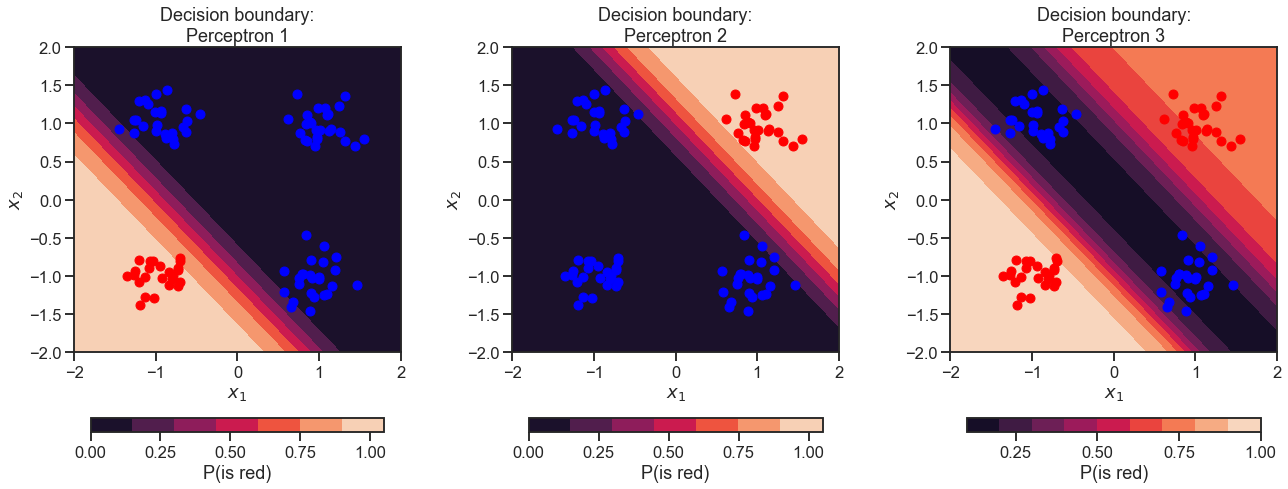

In [14]:
# setup a meshgrid (each x1 and x2 coordinate for which we want to predict a probability)
xx1, xx2 = np.meshgrid(np.linspace(-2,2,100), np.linspace(-2,2,100))

# predict with perceptron 1 & 2
zz1 = p1.predict(np.c_[xx1.ravel(), xx2.ravel()])
zz2 = p2.predict(np.c_[xx1.ravel(), xx2.ravel()])
# standardize
zz1_stand = (zz1 - np.mean(zz1, axis=0)) / np.std(zz1, axis=0)
zz2_stand = (zz2 - np.mean(zz2, axis=0)) / np.std(zz2, axis=0)
# predict with perceptron 3, based of prediction of perceptron 1 & 2
zz3 = p3.predict(np.c_[zz1_stand.ravel(), zz2_stand.ravel()])

# plot
fig, axs = plt.subplots(1, 3, figsize=(18,7))
for i, (y, zz) in enumerate(zip([y1, y2, y3], [zz1, zz2, zz3])):
    ax = axs[i]
    cs = ax.contourf(xx1, xx2, zz.reshape(xx1.shape))
    cbar = fig.colorbar(cs, ax=ax, shrink=0.9, orientation="horizontal")
    cbar.set_label('P(is red)')
    cbar.set_ticks([0, 0.25, 0.5, 0.75, 1])
    for j in range(y.shape[0]):
        if y[j] == 0:
            marker = 'bo'
        else:
            marker = 'ro'
        ax.plot(X[j][0], X[j][1], marker)
    ax.set_xlabel(r'$x_1$')
    ax.set_ylabel(r'$x_2$')
    ax.set_title('Decision boundary:\nPerceptron {}'.format(i+1))

fig.tight_layout(w_pad=4)
fig.savefig('figures/Figure-1-2_Multi-Perceptron-Decision-Boundaries.png', dpi=600)

Super cool! By combining three perceptrons, we have managed to learn a decision boundary for data that is not linearly separable!

**This idea to sequentially combine multiple simple but non-linear functions to a single classifier (or network) forms the basis of deep learning!**

Below, we will explore this idea further.

# 3. Artificial neural networks 

A network of multiple perceptrons (or neurons) that are sequentially combined to form a single perdictive system is called an "artificial neural network" (or ANN).

The most basic neural network architecture consists of the following elements (see the figure below):

- An *input* layer, representing an instance of the input data

- One or multiple *hidden* layer(s), each containing several neurons

- An *output* layer, containing one output neuron for each target class in the dataset

In the illustration below, the input data is an image of a single handwritten digit. This image has 8x8 pixels; To serve it to our ANN, we would flatten it to be a single vector of 64 values. The input layer therefore would have 64 input neurons (each representing one of the 64 input features).

As the data consists of single handwritten digits, we would set the output layer to contain 10 neurons (one for each digit between 0 and 9).

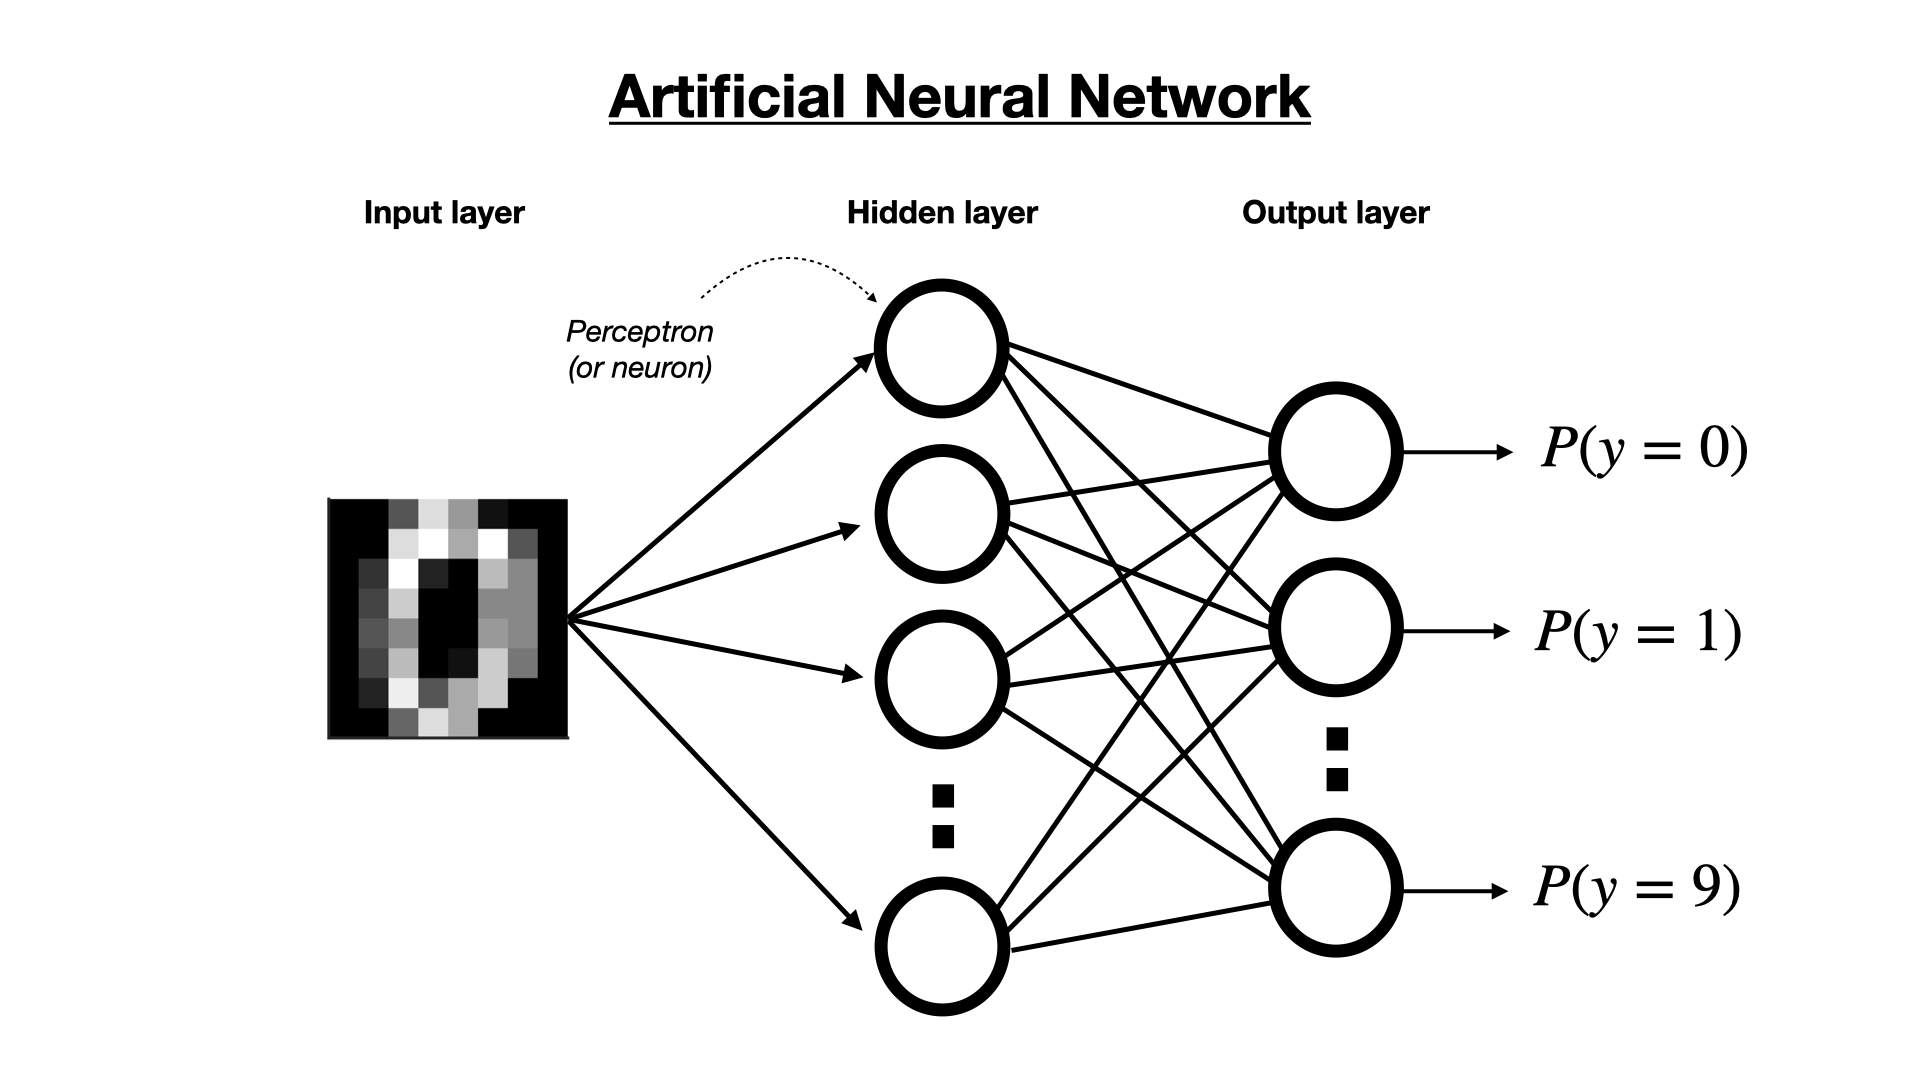

In [15]:
Image(filename='materials/images/free-use/Artificial-Neural-Network.png')

In contrast to our previous example (in which we separately trained three individual perceptrons), an ANN uses linear algebra wizardry to train and perfom all computations efficiently and in parallel.

Specifically, an ANN represents all neurons of a layer as a single matrix: 

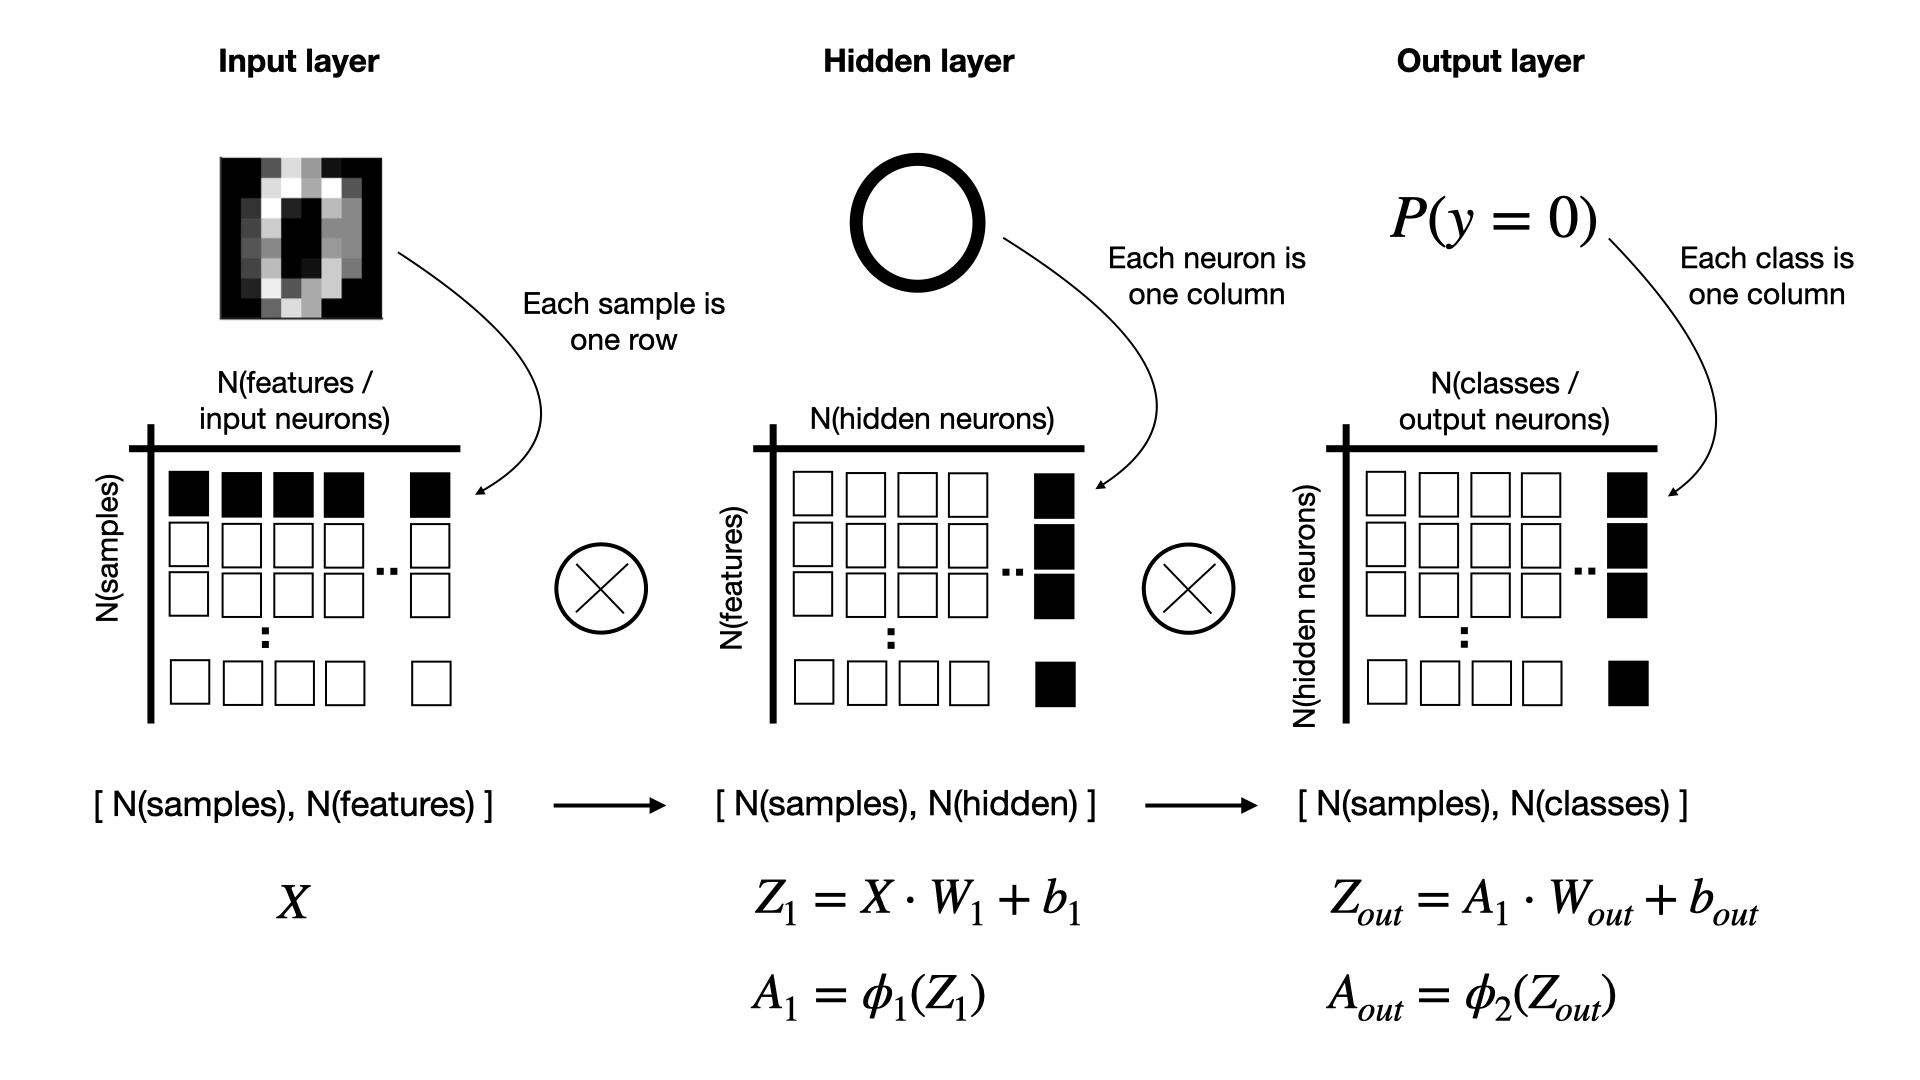

In [16]:
Image(filename='materials/images/free-use/ANN-Forward-Pass.png')

The input layer is represented by the data matrix $X$, containing one data sample (or instance) in each row and one column for each feature of the data (these features are often also called input neurons).

The hidden layer is represented by a weight-matrix $W$: It contains one row for each feature (or input neuron) of its input and one column for each of its own neurons.

Similarly, the output layer is also represented by a weight matrix $W$, containing one row for each neuron of the previous hidden layer and one column for each target class in the data (each representing one output neuron).

Importantly, each hidden layer (as well as the output layer) also contains a vector of bias terms $b$ (with one vlaue for each neuron of the layer).

Let's quickly settle on some notation that will use throughout the following:

- $X$: The input data
- $Z = X \cdot W + b$: The weighted sum of the input to a layer multiplied by the layer's weights as well as the addition of the bias terms
- $A = \phi(Z)$: The application of the activation function ($\phi$) of a hidden layer to $Z$ (e.g., the sigmoid function in our previous example)

To get a better feel for how this works, let's play it through really quick, with random weights:

In [17]:
# we will use our previous X, containing 100 instances with two values per instance:
print(X.shape)

(100, 2)


Ok, lets say our hidden layer has 10 neurons; The weight matrix would then be of shape (2, 10):

In [18]:
np.random.seed(1342)
# weights and bias of hidden layer:
W_hidden  = np.random.normal(size=(2,10))
b_hidden = np.random.normal(size=(1,10)) # one bias for each neuron

We have two output classes (blue and red); We can model these two classes with a single output neuron that is activated through the sigmoid function (if its output is >0.5, we predict $y = 1$). The output layer therefore has only 1 neuron with one weight for each neuron of the previous hidden layer (resulting in a shape of (10,1)):

In [19]:
np.random.seed(473)
# weights and bias of output layer:
W_output  = np.random.normal(size=(10,1))
b_output = np.random.normal(size=(1,1)) # one bias for each neuron

Ok, the let's put this all together:

In [20]:
Z_hidden = X.dot(W_hidden) + b_hidden
A_hidden = sigmoid(Z_hidden) # here we use the sigmoid as out hidden layer activation funcion
A_hidden.shape

(100, 10)

As we can see, the output of our hidden layer contains 100 entries with each 10 values (each representing the activation of one of our 10 hidden layer neurons).

In [21]:
Z_output = A_hidden.dot(W_output) + b_output
A_output = sigmoid(Z_output)
A_output.shape

(100, 1)

Similarly, the output of our random ANN contains 100 entries with each one value, representing the probability that each entry belongs to class 1 of our data.

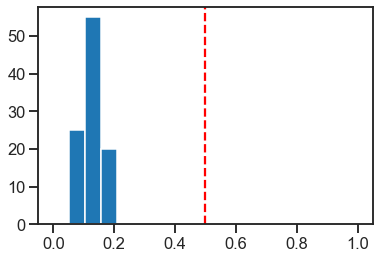

In [22]:
_ = plt.hist(A_output, np.linspace(0,1,20))
plt.axvline(0.5, color='r', ls='--')

As our weights are set random, the ANN wrongly "predicts" all instances to have class 0 (all probabilities are < 0.5).

# 4. Backpropagation

The second main ingredient of modern deep learning is the [backpropagation](https://en.wikipedia.org/wiki/Backpropagation) algorithm.

The goal of the backpropagation algorithm is to enable the "integrated" training of all neurons of an ANN - In contrast to our previous example, in which we trained three perceptrons separately, the goal of the backpropagation algorithm is define the partial derivatives of the loss function w.r.t. to each weight of each neuron in the network. Conceptually, these partial derivartives describe how much the current value of the loss function is dependent on each weight (how much each weight contributed to the current error). 

As in our previous gradient descent implementation, we need to obtain these partial derivatvies to update the weights of each neuron in each gradient descent step.

In a nutshell, the backpropagation algorithm procedes as follows (also see the figure below):

1. In a first step, the backpropagation algorithm looks at the prediction $A_{out}$ of the ANN (resulting from a forward pass) and computes the partial derivative of the loss function $L$ w.r.t. the prediction (we will refer to this as: $\frac{dL}{dA_{out}}$): This partial derivative simply describes how much the loss function changes with  a change in the predictions $A_{out}$ of the ANN. 


2. Subsequently, the backpropagation algorithm looks at the output $Z_{out}$ of the ANN's output layer and estimates how much the prediction $A_{out}$ changes with $Z_{out}$ (by computing the partial derivative $\frac{dA_{out}}{dZ_{out}}$). By the use of this partial derivative, the algorithm can then also obtain the partial derivative of our loss function $L$ w.r.t. the output $Z_{out}$: To do this it uses the [chain rule](https://en.wikipedia.org/wiki/Chain_rule) and simiply multiplies the previously obtained partial derivative $\frac{dL}{dA_{out}}$ with the partial derivative of the output activation function $\frac{dA_{out}}{dZ_{out}}$ (describing how much $A_{out}$ changes with $Z_{out}$): $\frac{dL}{dZ_{out}} = \frac{dA_{out}}{dZ_{out}} \times \frac{dL}{dA_{out}} $ 

    Note that for the combination of sigmoid (or softmax) activation function and cross-entropy loss this partial derivative breaks down to $\frac{dL}{dZ_{out}} = A_{out} - y$ and is hence often also refered to as the "error term".


3. In a next step, the backpropagation algorithm goes back through every hidden layer of the ANN and estimates how much the output $Z_L$ of each layer $L$ has contributed to the current value of the loss function (by computing the partial derivative $\frac{dL}{dZ_L}$ for each layer). By the use of the chain rule, this is simply: $\frac{dL}{dZ_{L-1}} = \frac{dA_{L-1}}{dZ_{L-1}} \times \frac{dZ_{L}}{dA_{L-1}} \times \frac{dL}{dZ_L}$ 


4. Lastly, the backpropagation algorithm computes the partial derivatives $\frac{dL}{dW_L}$ from the previously obtained derivatives $\frac{dL}{dZ_L}$: $\frac{dL}{dW_{L}} = \frac{dZ_L}{dW_L} \times \frac{dL}{dZ_L}$ (describing how much the loss function $L$ chanegs w.r.t. the weights $W_L$). In typical gradient descent fashion, we can then use these partial derivatives to update out ANN weights: $W_L -= \alpha \times \frac{dL}{dW_{L}}$ ($\alpha$ again describes the learning rate).




For more details on the mechanics of the backpropagation algorithm, please see: 
- https://www.youtube.com/watch?v=Ilg3gGewQ5U&t=387s
- https://www.youtube.com/watch?v=tIeHLnjs5U8&t=353s
- https://www.youtube.com/watch?v=yXcQ4B-YSjQ&t=711s

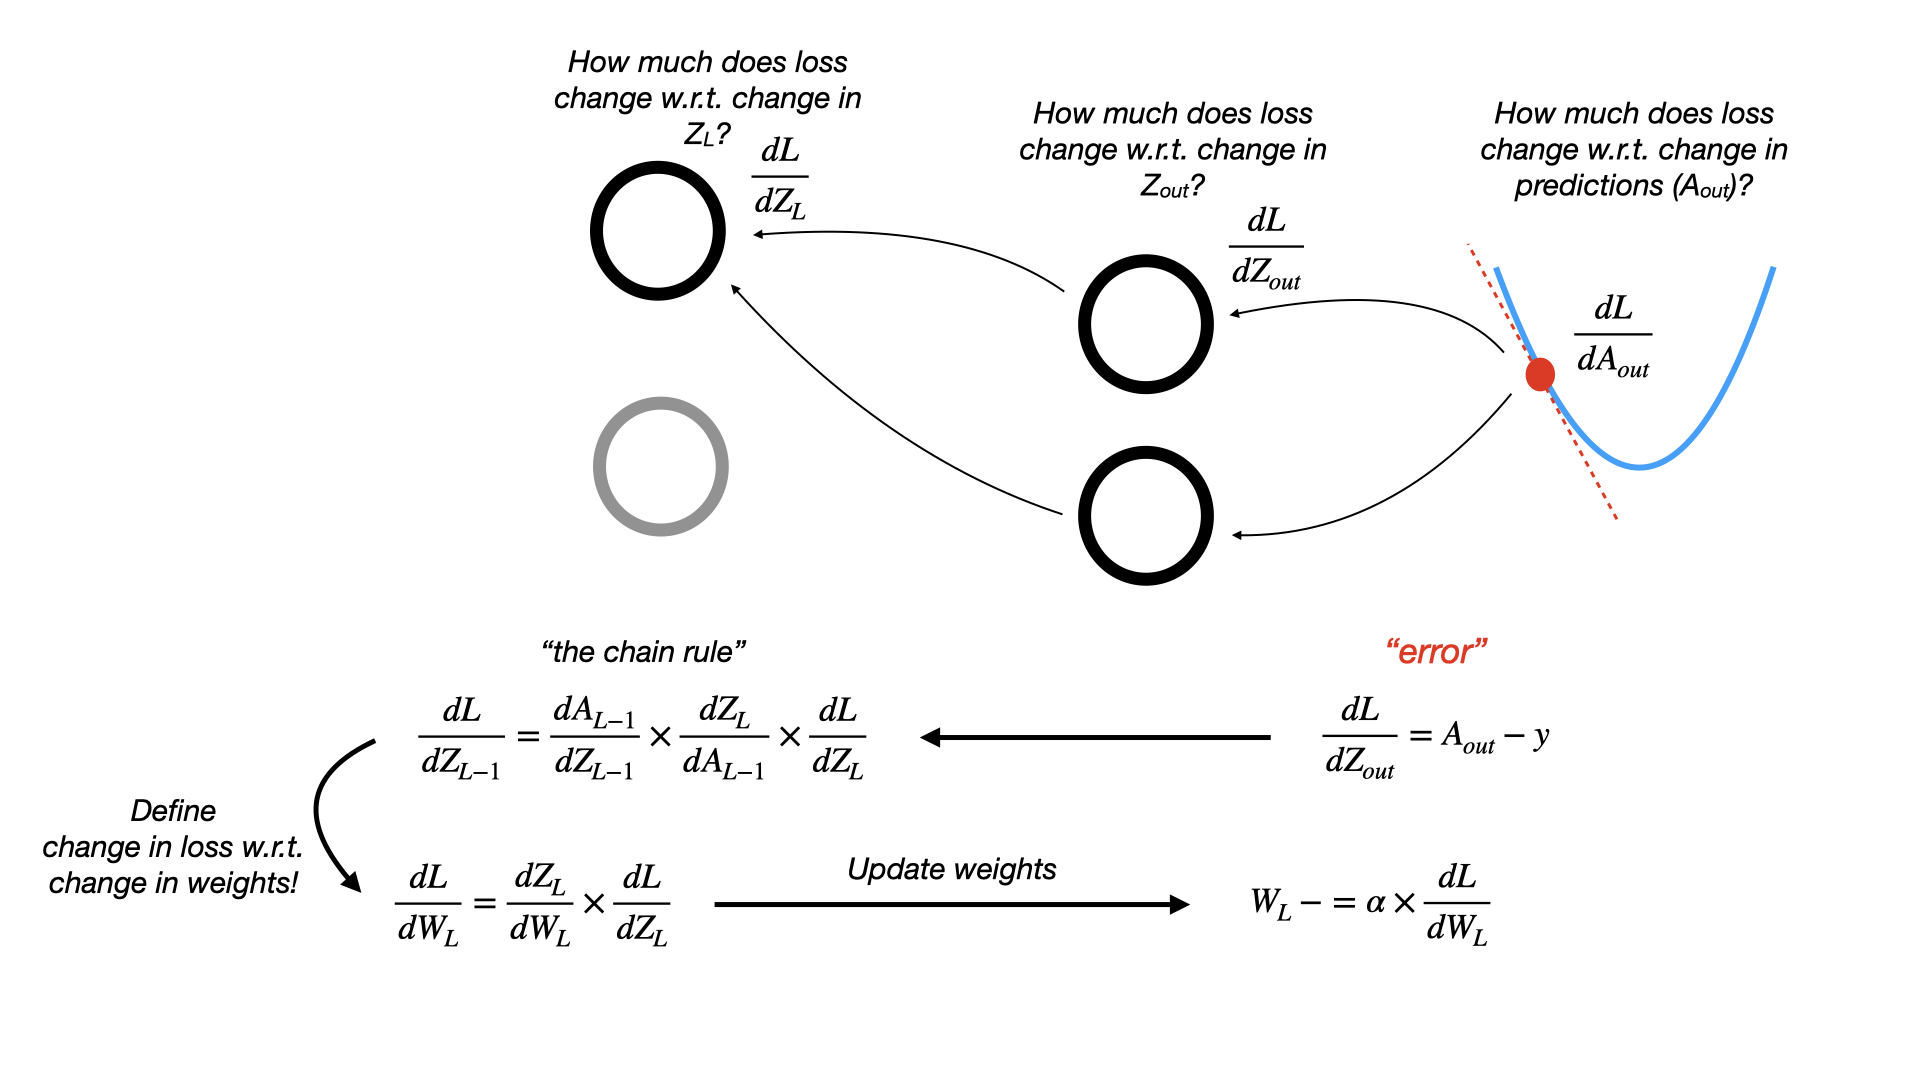

In [23]:
Image(filename='materials/images/free-use/ANN-Backpropagation.png')

# 5. Our Artificial Neural Network implementation 

OK, let's put all of this together into an implementation of an ANN:

In [24]:
# the sigmoid activation function

class sigmoid():
    """the sigmoid function
    """
    def __init__(self):
        self.name = 'sigmoid'
        
    def forward(self, x):
        """forward pass with the sigmoid function
        """
        return 1./(1.+np.exp(-x))
    
    def derivative(self, a):
        """the derviative g'(a) of the sigmoid function,
        given its activations a (resulting from the forward pass)
        """
        return a*(1-a)

In [25]:
class NeuralNetwork:
    """A simple Neural Network implementation.
    
    Args: 
        n_in (int): number of input neurons
        n_out (int): number of output neurons
        n_hidden (array of ints): number of neurons for each layer:
            an array of [10, 10] would create two hidden 
            layers with 10 neurons each
        activations (array of functions): activation for each hidden layer
            as well as the output layer; This should contain one activation
            function for each of the hidden layers (as specified with 
            n_hidden) as well as one for the output layer (this should be 
            the last entry of the array). If None, all activations are
            set to the sigmoid function.
            Importantly, each activation needs to be a
            class with two functions for the forward pass and
            the derivative w.r.t. the resulting activations 
            (see for example the sigmoid implementation)
        seed (int): random seed to allow for reproducibiliy
            
    """
            
    def __init__(self, n_in, n_out, n_hidden=[10], activations=None, seed=123):
        
        # init
        self.n_in = n_in
        self.n_out = n_out
        self.n_hidden = np.append(np.array(n_hidden), n_out).astype(np.int) # add output layer
        self.n_layers = self.n_hidden.size
        self.training_loss = [] # we will use this to collect the loss values during gradient descent
        self.seed = seed
        
        # initialize weights & biases
        self.parms = {} # a dictionary containing all network parameters    
        np.random.seed(self.seed)
        n_in = int(self.n_in)
        for layer, n_out in enumerate(self.n_hidden):
            self.parms["W{}".format(layer)] = self._initialize_weight([n_in, n_out])
            self.parms["b{}".format(layer)] = self._initialize_weight([1, n_out])
            # also create empty storage for neuron activations
            self.parms["A{}".format(layer)] = np.zeros((n_in, n_out)) 
            n_in = int(n_out)
        
        # set layer activations
        if activations is None:
            # if no activations are given, use sigmoid
            self.activations = [sigmoid()] * self.n_layers
        else:
            if len(activations) != self.n_layers:
                raise ValueError('/!\ Number of activations does not match number of layers.')
            self.activations = [a() for a in activations]
             
                
    def _initialize_weight(self, size, bound=1):
        """Draw weights randomly from 
        a uniform distribution between -1 and 1
        """
        return np.random.uniform(-1, 1, size=size)
    
    
    def forward(self, X):
        """forward pass of the neural network,
        given a dataset X
        
        Args: 
            X (ndarray): input data with one instance 
                per row and one column for each feature
                
        Returns:
            predicted probability (n_samples x n_output_neurons)
        """
        self.parms['X'] = X
        for layer in range(self.n_layers):
            Z = X.dot(self.parms['W{}'.format(layer)]) + self.parms['b{}'.format(layer)]
            A = self.activations[layer].forward(Z)
            X = A
            self.parms["A{}".format(layer)] = A
        self.y_pred = A
        return A
        
        
    def predict(self, X):
        """predict classes for each instance
         of an input dataset X
        
        Args: 
            X (ndarray): input data with one instance 
                per row and one column for each feature
                
        Returns:
            predicted class for each instance
        """
        y_pred = self.forward(X)
        if self.n_out == 1:
            return np.array(y_pred > 0.5).astype(np.int).ravel()
        else:
            return np.argmax(y_pred, axis=1).ravel()
    
    
    def loss(self, X, y, zerotol=1e-10):
        """compute mean cross entropy loss,
        over the samples of an input dataset (X) and a set 
        of corresponding class labels (y).
        
        Args: 
            X (ndarray): input data with one instance 
                per row and one column for each feature
            y (ndarray): class label for each instance. 
                Importantly, if n_out > 1, y needs to be 
                one-hot encoded: such that it is of
                shape (n_samples x n_out)
        
        Returns:
            Average cross entropy loss"""
        if self.activations[-1].name not in ['sigmoid', 'softmax']:
            raise ValueError('loss function only valid for sigmoid or softmax output activations.')
        y_pred = self.forward(X)
        loss = -y * np.log(y_pred + zerotol) 
        loss -= (1 - y) * np.log(1 - y_pred + zerotol)
        return 1.0/X.shape[0] * np.sum(np.sum(loss, axis=1), axis=0)
    
    
    def derivative_loss(self, x, y):
        """derivative of cross entropy loss"""
        if self.activations[-1].name not in ['sigmoid', 'softmax']:
            raise ValueError('derivative of loss only valid for sigmoid / softmax output activations.')
        y_pred = self.forward(x)
        return y_pred - y
        
        
    def backward(self, x, y, lr=0.1):
        """compute gradient descent backward pass,
        updating all network weights, given an
        input dataset (X) and a set of corresponding 
        class labels (y).
        
        Args: 
            X (ndarray): input data with one instance 
                per row and one column for each feature
            y (ndarray): class label for each instance. 
                Importantly, if n_out > 1, y needs to be 
                one-hot encoded: such that it is of
                shape (n_samples x n_out)
            lr (float): learning rate for weight update
        """
        y_pred = self.forward(x)
        self.training_loss.append(self.loss(x, y))
        dZ = self.derivative_loss(x, y)
        for layer in range(1, self.n_layers)[::-1]: # iterate hidden layers backward
            dW = 1.0/dZ.shape[0] * self.parms["A{}".format(layer-1)].T.dot(dZ)
            db = 1.0/dZ.shape[0] * np.sum(dZ, axis=0, keepdims=True)
            self.parms["W{}".format(layer)] -= self.lr * dW
            self.parms["b{}".format(layer)] -= self.lr * db
            # compute dZ for next lower layer
            dA = dZ.dot(self.parms["W{}".format(layer)].T)
            dZ = dA * self.activations[layer-1].derivative(self.parms["A{}".format(layer-1)])
        # input layer
        dW = 1.0/dZ.shape[0] * self.parms["X"].T.dot(dZ)
        db = 1.0/dZ.shape[0] * np.sum(dZ, axis=0, keepdims=True)
        self.parms["W0"] -= self.lr * dW
        self.parms["b0"] -= self.lr * db
          
            
    def fit(self, X, y, lr=0.1, n_steps=10000, batch_size=32, verbose=False):
        """fit the neural network to an input dataset.
        
        Args: 
            X (ndarray): input data with one instance 
                per row and one column for each feature
            y (ndarray): class label for each instance. 
                Importantly, if n_out > 1, y needs to be 
                one-hot encoded: such that it is of
                shape (n_samples x n_out)
            lr (float): learning rate for weight update
            n_steps (int): number of gradient descent steps
                to perform
            batch_size (int): number of random samples 
                drawn from the dataset at each gradient descent iteration
            verbose (bool): whether or not to give a printed update
                about the state of the training"""
        # make sure y is right shape
        if self.n_out == 1 and np.ndim(y) < 2:
            y = y.reshape(-1,1)  
        assert np.ndim(y) == 2, '/!\ y needs to be 2 dimenional'
        # make sure data and model match
        if y.shape[1]>1:
            if np.unique(y.argmax(axis=1)).size != self.n_out:
                raise ValueError('/!\ n_out does not match number of labels in y (dim-1)')
        if verbose:
            print('Beginning training for {} batches ({} samples/batch):'.format(n_steps, batch_size))
        self.lr = lr
        iterator = range(n_steps)
        for step in (tqdm(iterator) if verbose else iterator):
            batch_i = np.random.choice(X.shape[0], batch_size, replace=False)
            self.forward(X[batch_i])
            self.backward(X[batch_i], y[batch_i], lr=self.lr)
         
        
    def plot_training_stats(self, X, y, train_idx, test_idx, target_names=None):
        """plot the training loss as well as a confusion matrix
        for the training and test datasets.
        
        Args: 
            X (ndarray): input data with one instance 
                per row and one column for each feature
            y (array): class label for each instance. 
            train_idx (array): index indicating the
                position of the training instances in X and y
            test_idx (array): index indicating the
                position of the test instances in X and y
            target_names (array of strings): names of 
                target classes in y
                
        Returns:
            Matrplotlib figure and axes
                """
        fig, axs = plt.subplots(1,3,figsize=(20,6))
        # plot training loss
        axs[0].set_title('Training loss')
        axs[0].set_ylabel('Loss')
        axs[0].set_xlabel('Training step')
        axs[0].plot(self.training_loss, color='k')
        despine(ax=axs[0])
        # plot confusion matrix for training and test data
        for i, (label, idx) in enumerate(zip(['Training', 'Test'], [train_idx, test_idx])):
            y_pred = self.predict(X[idx])
            acc = np.mean(y_pred == y[idx])
            axs[1+i].set_title('{} data\nMean Acc.: {}%'.format(label, np.round(acc*100, 2)))
            conf_mat = confusion_matrix(y[idx], y_pred, normalize='true')
            sns.heatmap(conf_mat, annot=True, ax=axs[1+i], vmin=0, vmax=1,
                        annot_kws={'fontsize': 100./self.n_out}) # this might be too large for few classes
            if target_names is not None:
                axs[1+i].set_xticklabels(target_names)
                axs[1+i].set_yticklabels(target_names)
        fig.tight_layout()
        return fig, axs

# 6. What happens if we change the hidden layer activation function?

Ok, let's see if our implementation actually works and is able to distinguish between the red and blue points in our previous example.

... Let's also make this a bit more interesting by exchanging the activation function of the hidden layer.

For this, I have prepared three common activation functions (including their derivatives; see below): 
- the [rectified linear unit (or ReLu)](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)),
- [hyperbolic tangent (or tanh)](https://mathworld.wolfram.com/HyperbolicTangent.html), and
- [softmax](https://en.wikipedia.org/wiki/Softmax_function). 

Note that the softmax function is typically used as the output layer activation for classification problems with more than two mutually-exclusive classes (in which each sample can only belong to one out of $N$ classes).

In [26]:
class relu():
    def __init__(self):
        self.name = 'relu'
        
    def forward(self, x):
        return np.maximum(x, 0)
    
    def derivative(self, a):
        d = np.zeros_like(a)
        d[a<=0] = 0
        d[a>0] = 1
        return d
    
    
class tanh():
    def __init__(self):
        self.name = 'tanh'
        
    def forward(self, x):
        return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
    
    def derivative(self, a):
        return 1-a**2
    
    
class softmax():
    def __init__(self):
        self.name = 'softmax'
        
    def forward(self, x):
        e_x = np.exp(x)
        return e_x / e_x.sum(axis=1, keepdims=True)
    
    def derivative(self, a):
        SM = a.reshape((-1,1))
        return (np.diagflat(a) - np.dot(SM, SM.T)).sum(axis=1)

We will further use one output neuron for each of the two classes of our example dataset.

We therefore set `n_out = 2` in our specification of the ANN.

By doing so, we also need to change the encoding of our target (y), so that it has one value for each of the two output neurons. This type of encoding is common in machine learning and called one-hot encoding. It looks like this: 

if y = 0: [1, 0], if y = 1: [0, 1]; 

Thereby `y.argmax(axis=1)` will result in our original y.

In [27]:
y_onehot = np.zeros((y.size, 2))
y_onehot[np.arange(y.size), y.ravel()] = 1
print('This is how one-hot encoding looks like for class 0:')
print(y_onehot[0])
print('And this is how it looks for class 1:')
print(y_onehot[n_samples])
print('\nOverall, y now has dimension: {}x{}'.format(*y_onehot.shape))

This is how one-hot encoding looks like for class 0:
[1. 0.]
And this is how it looks for class 1:
[0. 1.]

Overall, y now has dimension: 100x2


As the two classes (red and blue) are mutually exclusive, we further use the softmax activation function for the output layer:

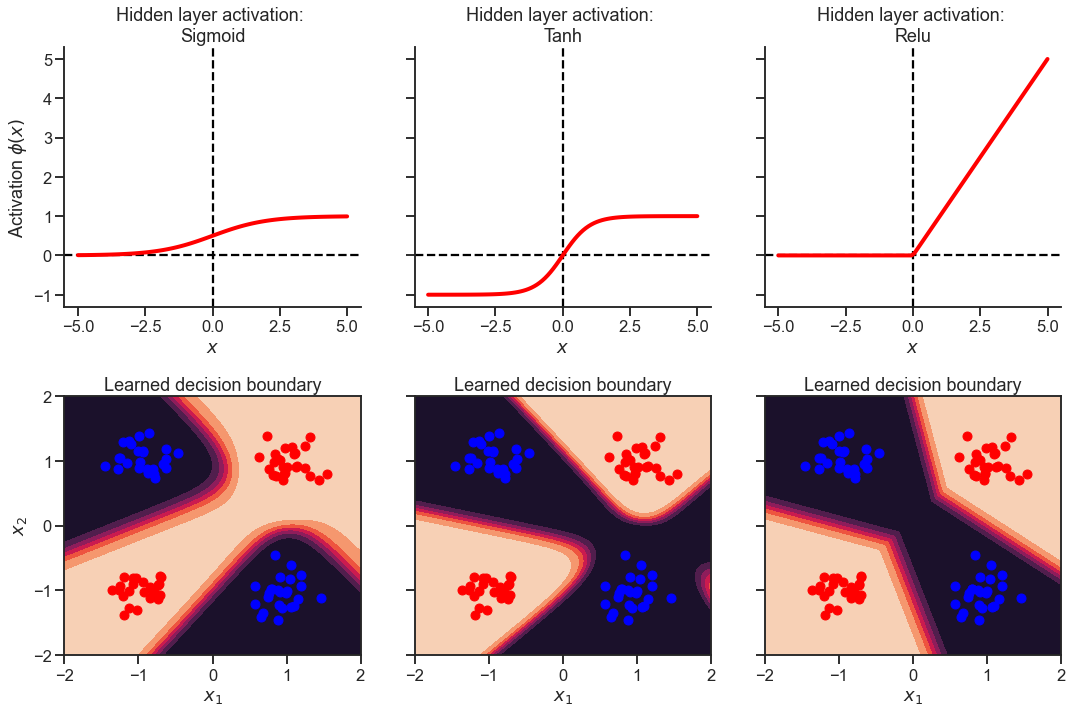

In [28]:
# set a random seed
seed = 159
np.random.seed(seed)

# setup figure
fig, axs = plt.subplots(2,3,figsize=(15,10), sharey='row', sharex='row')

# iterate activation functions
for i, act in enumerate([sigmoid, tanh, relu]):
    
    # plot activation function of hidden layer
    ax = axs[0,i]
    x = np.linspace(-5,5,100)
    ax.axhline(0, color='k', ls='--')
    ax.axvline(0, color='k', ls='--')
    ax.plot(x, act().forward(x), color='red', lw=4)
    ax.set_title('Hidden layer activation: \n{}'.format(act().name.capitalize()))
    ax.set_xlabel(r'$x$')
    despine(ax=ax)
    
    # make and fit neural network instance
    nn = NeuralNetwork(n_in=2, n_out=2, n_hidden=[3], activations=[act, softmax], seed=seed)
    nn.fit(X, y_onehot, verbose=False)
    
    # perdict probabilities
    zz = nn.forward(np.c_[xx1.ravel(), xx2.ravel()])
    zz = zz[:,1].reshape(xx1.shape)
    
    # plot decision boundary
    ax = axs[1,i]
    cs = ax.contourf(xx1,xx2,zz)
    for i in range(y.shape[0]):
        if y[i] == 0:
            marker = 'bo'
        else:
            marker = 'ro'
        ax.plot(X[i][0], X[i][1], marker)
    ax.set_title('Learned decision boundary')
    ax.set_xlabel(r'$x_1$')
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)

# some final plotting settings
axs[0,0].set_ylabel('Activation '+r'$\phi(x)$')
axs[1,0].set_ylabel(r'$x_2$')

# save figure
fig.tight_layout(h_pad=2, w_pad=4)
fig.savefig('figures/Figure-1-3_Neural-Network-Hidden-Activations.png', dpi=600)

Cool! Our ANN correctly distinguishes between the two classes for all three different hidden layer activation functions.

Interestingly, the learned decision boundary changes with the different activation functions.

# 7. Exercise 2: Classify handwritten digits

For our second exercise, we will utilize a dataset that contains small grey-scale images of handwritten digits.

This dataset is part of the scikit-learn library and we can load it as follows:

In [29]:
from sklearn.datasets import load_digits

In [30]:
data = load_digits()

`data`is a dictionary with the following elements: 

In [31]:
data.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

The digit label is encoded in the `target` entry:

In [32]:
data['target']

array([0, 1, 2, ..., 8, 9, 8])

The 1797 images of the dataset are stored in `data`.

Importantly, each image is flattened to 64 values. To visualize a few examples, we reshape each sample to 8 x 8 pixels.

In [33]:
data['data'].shape

(1797, 64)

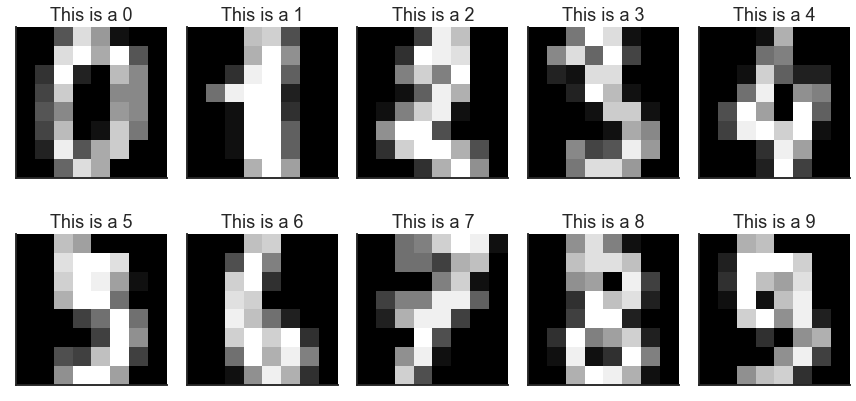

In [34]:
fig, axs = plt.subplots(2,5,figsize=(12,6))
axs = axs.ravel()
for i in range(10):
    axs[i].imshow(data['data'][i].reshape(8,8), cmap='gray')
    axs[i].set_title('This is a {}'.format(data['target'][i]))
    despine(ax=axs[i])
    axs[i].set_xticks([])
    axs[i].set_yticks([])
fig.tight_layout()
fig.savefig('figures/')
fig.savefig('figures/Figure-1-4_Hand-Written-Digits.png', dpi=600)

To classifiy the images with our neural network, we will also create a one-hot encoding of the y-vector (this is necessary so that we can use 10 output neurons):

In [35]:
# create X & y data
X = data['data']
y = data['target']

# create a one-hot version of y
y_onehot = np.zeros((y.size, np.unique(y).size))
y_onehot[np.arange(y.size), y] = 1
assert np.all(np.argmax(y_onehot, axis=1) == y), '/!\ Error in one-hot encoding'

We will further separate the data into a distinct training and test dataset:

In [36]:
np.random.seed(1827)
# train / test split
train_idx = np.random.choice(X.shape[0], int(0.7 * X.shape[0]), replace=False)
test_idx = np.array([i for i in np.arange(X.shape[0]) if i not in train_idx])
assert np.all([i not in train_idx for i in test_idx]), '/!\ Overlapping training and test datasets.'

Now we are ready to setup and train our neural network on the training data!

Let's create a simple network with 1 hidden layer and 10 neurons in this layer:

In [37]:
# set a random seed
seed = 2130
np.random.seed(seed)

# setup
nn = NeuralNetwork(n_in=X.shape[1], # the number of input neurons (or data features)
                   n_out=y_onehot.shape[1], # the number of ourput neurons (or classes, here 10)
                   n_hidden=[10], # 10 hidden neurons in a single hidden layer
                   activations=[sigmoid, softmax], # we use the sigmoid activation function for the hidden layer
                   seed=seed)

# training:
nn.fit(X=X[train_idx], y=y_onehot[train_idx], lr=0.01,  n_steps=20000, verbose=True)

  2%|▏         | 420/20000 [00:00<00:04, 4196.13it/s]

Beginning training for 20000 batches (32 samples/batch):


100%|██████████| 20000/20000 [00:05<00:00, 3843.09it/s]


By the use of our handy `plot_training_stats` function, we can get a quick overview of the training statistics as well as the network's predictive performance in the training and test data:

(<Figure size 1440x432 with 5 Axes>,
 array([<AxesSubplot:title={'center':'Training loss'}, xlabel='Training step', ylabel='Loss'>,
        <AxesSubplot:title={'center':'Training data\nMean Acc.: 83.37%'}>,
        <AxesSubplot:title={'center':'Test data\nMean Acc.: 76.85%'}>],
       dtype=object))

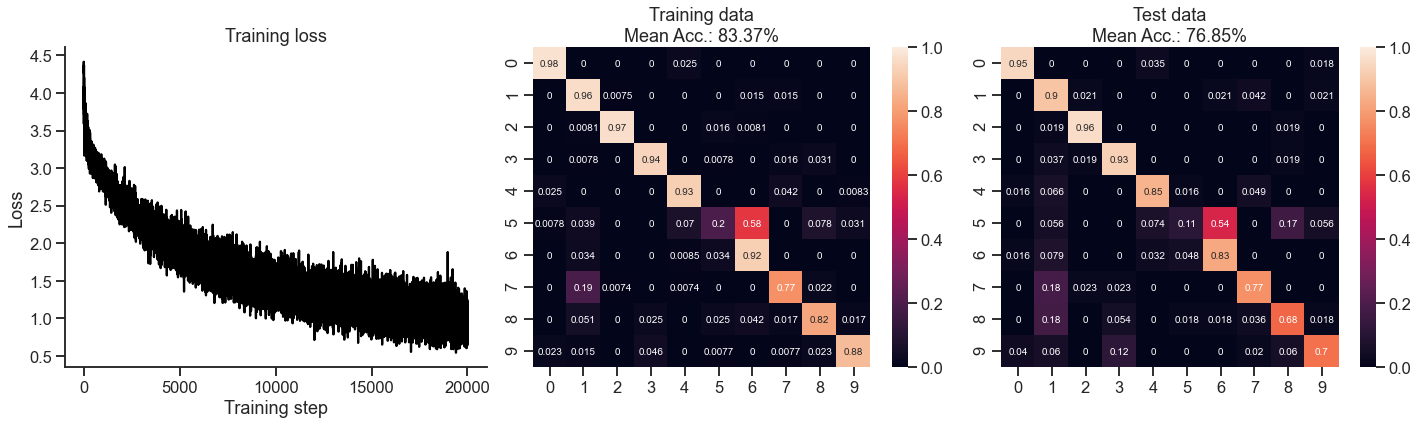

In [38]:
nn.plot_training_stats(X=X, y=y,
                       train_idx=train_idx,
                       test_idx=test_idx,
                       target_names=data['target_names'])

Ok, not bad; almost $77$% prediction accuracy in the test dataset.

Can you beat this?

**Try adjusting the hidden layer activations, as well as the number of number of hidden layers and the number of neurons per hidden layer in the code above.**

You can increase the number of hidden layers by adding numbers to `n_hidden`: `n_hidden = [10,10]` would create two hidden layers with 10 neurons each.